In [56]:
from typing import List, Optional
from autograd import grad, jacobian, elementwise_grad
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from tqdm import tqdm
import math
import scipy 
from scipy import linalg
from numpy import linalg as LA
from pyblas.level1 import dnrm2

sys.path.insert(0, os.path.join(".."))
%reload_ext autoreload
%autoreload 2

In [129]:
from lib import problems as pr
from lib import optimisers as opt
from lib import utils as ut
from lib.logistic_regression import LogisticRegression

In [237]:
A = np.genfromtxt("../data/framingham.csv", delimiter=',', missing_values='NA', filling_values=0, skip_header=1, usecols=(1,4,5,9,10,11,12,13,14))
b = np.genfromtxt("../data/framingham.csv", delimiter=',', skip_header=1, usecols=(15))
b = b * 2 - 1

In [238]:
print(A.shape)

(4240, 9)


In [303]:
A = A[:1000]
b = b[:1000]
A = A / A.max(axis=0)

In [304]:
print(A.shape)
print(b.shape)

(1000, 9)
(1000,)


In [305]:
problem = LogisticRegression(0.2, A, b, L_y=8)

In [306]:
print(emr.L_xy, emr.mu_xy)
ny, nx = problem.A.shape

0.04577130334971994 1.907179531540973e-12


In [308]:
print(problem.loss(np.ones(nx), -np.ones(ny)))
print(problem.xopt)
print(problem.yopt)

3.6174902160217366
[-0.32251799 -0.0623093   0.00162686 -0.23879661 -0.20037993 -0.28123076
 -0.27658168 -0.2860679  -0.14508469]
[ 0.2227949   0.27021387  0.0853638  -0.0601823   0.12045986  0.07142116
 -0.03007198  0.16037621  0.10033339  0.11521952  0.07554929  0.15658276
  0.22014753  0.11046924  0.20968382  0.18363804  0.03132501  0.1436097
  0.16287233  0.19206098  0.07564482  0.18521331  0.02919702  0.03912735
  0.05050359  0.07217304  0.12709765  0.12798169  0.11844805  0.1137064
  0.08424381  0.11827973  0.07408844  0.01130815  0.07238178  0.36150536
  0.07828588  0.03226736  0.05107557  0.18076985  0.12613163  0.14635398
  0.04308976  0.0886809  -0.26390488  0.08881437  0.09304152  0.10248534
  0.08239886  0.14562012 -0.05490085  0.17709765  0.06861453 -0.01562138
  0.2423167   0.15034955  0.16231607  0.06453843  0.07427795  0.06238306
  0.15832719 -0.08388659  0.05397631  0.13338908  0.09352376  0.0297582
 -0.00602513  0.09711964  0.05220672  0.05966005 -0.01896733  0.078026

In [309]:
params = {"apdg": None,
          'lpd': None,
          'altgd': None
         }

x0 = np.random.randn(nx, )
y0 = np.random.randn(ny, )
iteration = 10000
methods_dict = ut.main(emr, iteration, x0.copy(), y0.copy(), params, eps=1e-6)

AltGD: 100%|████████████████████████| 10000/10000 [00:09<00:00, 1085.64it/s]
/home/flacon/.local/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
LPD: 100%|██████████████████████████| 10000/10000 [00:05<00:00, 1732.09it/s]


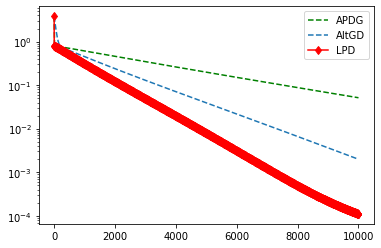

In [310]:
%matplotlib inline
plot_interval = 1
markevery=5
for method in methods_dict:
    if method in ["APDG", "LPD", "AltGD"]:
        plt.semilogy(np.arange(0, len(methods_dict[method]["loss_hist"])+plot_interval-1, plot_interval),
                     methods_dict[method]["loss_hist"][::plot_interval],
                     methods_dict[method]["marker"],
                     markevery=markevery,
                     label=method
                    )
plt.legend()

In [312]:
print(methods_dict["LPD"]["x_hist"][-1])

[-0.32255101 -0.06239554  0.00164648 -0.23884035 -0.20038241 -0.28121918
 -0.27661262 -0.2860499  -0.14508431]
